In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [18]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [19]:
from langsmith import Client

client = Client()

In [20]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_store = Chroma(
    embedding_function=OpenAIEmbeddings(model='text-embedding-3-large'),
    collection_name='real_estate_tax_collections',
    persist_directory='./real_estate_tax_collections'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [21]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

In [ ]:
from typing_extensions import TypedDict
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

class AgentState(TypedDict):
    query: str
    answer: str
    tax_base: str           # 과세표준 계산
    tax_base_equation: str  # 과세표준 계산 수식
    tax_deduction: str      # 공제금액
    tax_market_ratio: str   # 공정시장가액 비율

In [23]:
rag_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

In [24]:
tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 반환해주세요.'),
    ('human', '{tax_base_equation_information}')
])

def get_tax_base_equation(state: AgentState) -> AgentState:
    """
    'get_tax_base_equation' Node
    : 종합부동산세법 과세표준 계산 수식을 가져온다.
    
    Args:
        - state(AgentState): 에이전트의 현재 state

    Returns:
        - AgentState: 'tax_base_equation'를 포함하는 state
    """
    
    tax_base_retrieval_chain = (
        {
            'question': RunnablePassthrough(),
            'context': retriever
        } 
        | rag_prompt 
        | llm 
        | StrOutputParser()
    )
    tax_base_equation_chain = (
        {'tax_base_equation_information': RunnablePassthrough()}
        | tax_base_equation_prompt
        | llm
        | StrOutputParser()
    )
    get_tax_base_equation_chain = (
        {'tax_base_equation_information': tax_base_retrieval_chain}
        | tax_base_equation_chain
    )
    
    tax_base_equation_query = "주택에 대한 종합부동산세 계산시, 과세표준을 계산하는 방법 알려주세요."
    ai_message = get_tax_base_equation_chain.invoke(tax_base_equation_query)
    
    return {'tax_base_equation': ai_message}

In [25]:
def get_tax_deduction(state: AgentState) -> AgentState:
    """
    'get_tax_deduction' Node
    : 종합부동산세법 공제금액에 대한 정보를 가져온다.
    
    Args:
        - state(AgentState): 에이전트의 현재 state

    Returns:
        - AgentState: 'tax_deduction'를 포함하는 state
    """
    
    tax_deduction_chain = (
        {
            'question': RunnablePassthrough(),
            'context': retriever
        } 
        | rag_prompt 
        | llm 
        | StrOutputParser()
    )
    
    tax_deduction_query = "주택에 대한 종합부동산세 계산시, 공제금액을 알려주세요."
    ai_message = tax_deduction_chain.invoke(tax_deduction_query)
    
    return {'tax_deduction': ai_message}
    

In [26]:
from datetime import date

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f"아래 정보를 기반으로 공정시장 가액비율을 계산해주세요.\n\n{{context}}"),
    ('human', '{query}')
])

def get_tax_market_ratio(state: AgentState) -> AgentState:
    """
    'get_tax_market_ratio' Node
    : 웹 검색을 통해 주택 공시가격에 대한 공정시장가액비율을 가져온다.
    
    Args:
        - state(AgentState): 에이전트의 현재 state

    Returns:
        - AgentState: 'tax_market_ratio'를 포함하는 state
    """
    
    tax_market_ratio_query = f"오늘 날짜({date.today()}) 기준 주택 공시가격 공정시장가액비율은 몇%인가요?"
    context = tavily_search_tool.invoke(tax_market_ratio_query)
    
    tax_market_ratio_chain = tax_market_ratio_prompt | llm | StrOutputParser()
    ai_message = tax_market_ratio_chain.invoke({'context': context, 'query': tax_market_ratio_query})
    
    return {'tax_market_ratio': ai_message}

In [27]:
calculate_tax_base_prompt = ChatPromptTemplate.from_messages([
    (
        'system',
        """
        아래 주어진 정보를 기반으로 과세표준을 계산해주세요.
        
        - 과세표준 계산 공식: {tax_base_equation}
        - 공제금액: {tax_deduction}
        - 공정시장가액 비율: {tax_market_ratio}
        """
    ),
    ('human', "사용자의 주택 공시가격: {query}")
])

def calculate_tax_base(state: AgentState) -> AgentState:
    """
    'calculate_tax_base' Node
    : 종합부동산세법 과세표준을 계산한다.
    
    Args:
        - state(AgentState): 에이전트의 현재 state

    Returns:
        - AgentState: 'tax_base'를 포함하는 state
    """
    
    query = state['query']
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    tax_market_ratio = state['tax_market_ratio']
    
    calculate_tax_base_chain = calculate_tax_base_prompt | llm
    ai_message = calculate_tax_base_chain.invoke(
        {
            'query': query,
            'tax_base_equation': tax_base_equation,
            'tax_deduction': tax_deduction,
            'tax_market_ratio': tax_market_ratio,
        }
    )
    
    return {'tax_base': ai_message}
    

In [28]:
tax_rate_system_prompt = """
당신은 종합부동산세 계산 전문가입니다.
아래 문서를 참고해 사용자의 질문에 대한 종합부동산세를 계산해주세요.

[종합부동산세 세율]
{context}
"""
tax_rate_human_prompt = """
과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요.

- 과세표준: {tax_base}
- 주택수: {query}
"""

calculate_tax_rate_prompt = ChatPromptTemplate.from_messages([
    ('system', tax_rate_system_prompt),
    ('human', tax_rate_human_prompt)
])

def calculate_tax_rate(state: AgentState) -> AgentState:
    """
    'calculate_tax_rate' Node
    : 종합부동산세 세율을 계산한다.
    
    Args:
        - state(AgentState): 에이전트의 현재 state

    Returns:
        - AgentState: 'answer'를 포함하는 state
    """    
    
    query = state['query']
    tax_base = state['tax_base']
    context = retriever.invoke(query)
    
    calculate_tax_rate_chain = calculate_tax_rate_prompt | llm
    ai_message = calculate_tax_rate_chain.invoke(
        {
            'query': query,
            'tax_base': tax_base, 
            'context': context,
        }
    )
    
    return {'answer': ai_message}
    

In [ ]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(AgentState)

# nodes
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_tax_market_ratio', get_tax_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

# edges
graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_tax_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_tax_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [30]:
graph = graph_builder.compile()

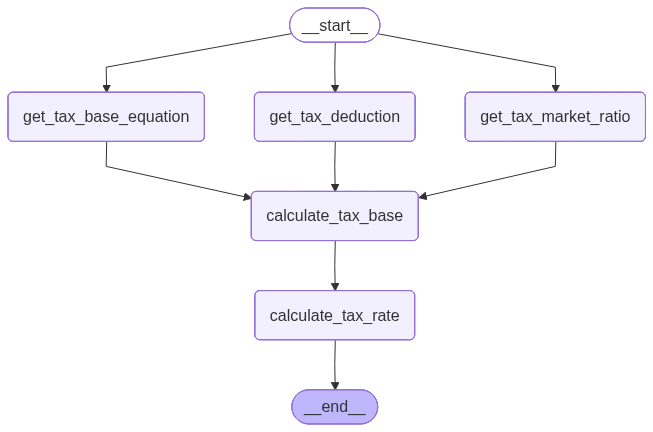

In [31]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
query = "5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있다면 세금이 얼마인가요?"
initial_state = {'query': query}

graph.invoke(initial_state)